## Tide Table for Cape Lookout

In [1]:
# imports and settings
import requests as req
import datetime
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Get today's date
today = datetime.date.today()
query_date = str(today).replace('-', '')

In [11]:
# Get the data
url = "https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={}&end_date={}&station=8656841&product=predictions&datum=MLLW&time_zone=lst&units=english&format=json".format(query_date, query_date)
data = req.get(url).json()  # Response object formatted as json 

for prediction in data['predictions'][0:5]:
    print(prediction)

{'t': '2021-04-03 00:00', 'v': '4.449'}
{'t': '2021-04-03 00:06', 'v': '4.407'}
{'t': '2021-04-03 00:12', 'v': '4.360'}
{'t': '2021-04-03 00:18', 'v': '4.308'}
{'t': '2021-04-03 00:24', 'v': '4.252'}


In [4]:
# Create Pandas DataFrame
tide_predictions = pd.DataFrame.from_dict(data['predictions'])
tide_predictions.head()

,t,v
0,2021-04-03 00:00,4.449
1,2021-04-03 00:06,4.407
2,2021-04-03 00:12,4.360
3,2021-04-03 00:18,4.308
4,2021-04-03 00:24,4.252


In [5]:
tide_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   t       240 non-null    object
 1   v       240 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB


In [6]:
# Rename columns and change data types 
tide_predictions.columns = ['Hour', 'Height']
tide_predictions['Hour']=tide_predictions['Hour'].str[-5:-3].astype(int) + (tide_predictions['Hour'].str[-2:].astype(int))/60
tide_predictions['Height']=tide_predictions['Height'].astype(float)
tide_predictions.sort_values('Hour')
tide_predictions.head()

,Hour,Height
0,0.0,4.449
1,0.1,4.407
2,0.2,4.360
3,0.3,4.308
4,0.4,4.252


In [7]:
tide_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hour    240 non-null    float64
 1   Height  240 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


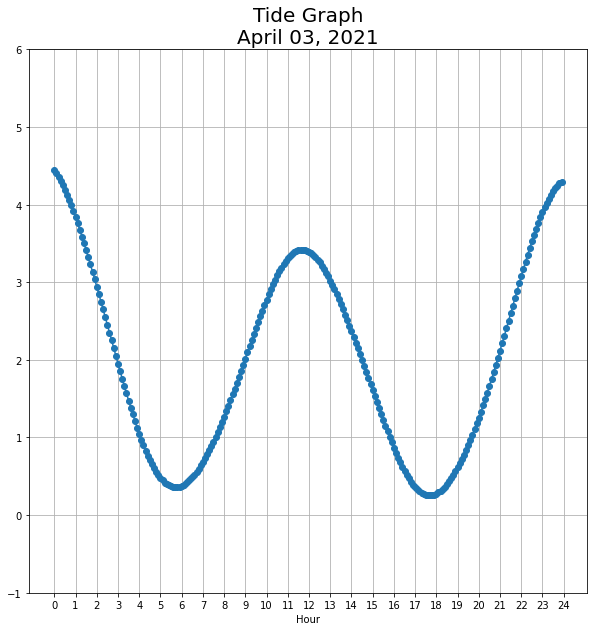

In [8]:
%matplotlib inline 
plt.figure(figsize=(10, 10))
plt.plot(tide_predictions['Hour'], tide_predictions['Height'], marker='o')
plt.ylim(-1, 6)
plt.title("Tide Graph\n{:%B %d, %Y}".format(today), fontsize=20)
plt.grid(axis='both')
plt.xticks(range(0, 25))
plt.xlabel('Hour')
plt.show()

In [15]:
# Calculate times for high and low tides. 

def max_tide(series):
    """
    Returns list of indices for which 'height' is a relative maximum.
    """
    maxima = []
    for i in range(238):
        if series.iloc[i] <= series.iloc[i+1] and series.iloc[i+1] >= series.iloc[i+2]:
            maxima.append(i+1)
    return maxima
        
def min_tide(series):
    """
    Returns list of indices for which 'height' is a relative minimum.
    """
    minima = []
    for i in range(238):
        if series.iloc[i] >= series.iloc[i+1] and series.iloc[i+1] <= series.iloc[i+2]:
            minima.append(i+1) 
    return minima

def hour_to_time(hpm):
    """
    Converts 'hours past midnight' to 'time of day'.
    """
    h = int(hpm)
    m = int(round((hpm - h) * 60, 0))
    if h == 0 or h == 12:
        hour = '12' 
    else:
        hour = str(h % 12)
    if m < 10:
        minute = '0' + str(m)
    else: 
        minute = str(m)
    if h < 12:
        meridiam = 'AM'
    else:
        meridiam = 'PM'
    return  hour + ':' + minute + ' ' + meridiam


maxima = max_tide(tide_predictions['Height'])
minima = min_tide(tide_predictions['Height'])

high_tide = tide_predictions.iloc[maxima].copy()
high_tide.loc[:, 'Event'] = 'High Tide'

low_tide = tide_predictions.iloc[minima].copy() 
low_tide.loc[:, 'Event'] = 'Low Tide'

tide_table = pd.concat([high_tide, low_tide], ignore_index=True)

tide_table['Time'] = tide_table['Hour'].apply(hour_to_time)
tide_table = tide_table[['Time', 'Hour', 'Height', 'Event']]
tide_table.sort_values('Hour', inplace=True, ignore_index=True)
# tide_table.index = list(range(tide_table.shape[0]))
tide_table

,Time,Hour,Height,Event
0,5:42 AM,5.7,0.360,Low Tide
1,11:42 AM,11.7,3.417,High Tide
2,5:42 PM,17.7,0.253,Low Tide
